# WIYN 2017A Observation Plan

## Top-Level Goals

* Get line-widths for 4-ish face-on spirals
* Dithered observations to get better spatial resolution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.gridspec as gridspec
import cycler

from astropy import table as t, units as u, constants as c, time
from astropy.io import fits
from astropy.coordinates import SkyCoord, SkyOffsetFrame
from astropy.time import Time, TimezoneInfo
from datetime import datetime
from astropy.wcs import WCS

In [3]:
import astroplan as ap
ap.download_IERS_A()
import astroquery as aq

import os, sys
if os.environ['MANGA_CONFIG_LOC'] not in sys.path:
    sys.path.append(os.environ['MANGA_CONFIG_LOC'])

import mangarc

if mangarc.tools_loc not in sys.path:
    sys.path.append(mangarc.tools_loc)

# personal
import manga_tools as m

## Set up plotting rcparams

In [4]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 6.
mpl.rcParams['ytick.labelsize'] = 6.
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = (4, 3)

## Set up eline catalog

In [6]:
# air wavelengths
elines = {'Ha': 6564.61 * u.AA,
          '[NII]_1': 6549.84 * u.AA,
          '[NII]_2': 6585.23 * u.AA,
          '[SII]_1': 6718.32 * u.AA,
          '[SII]_2': 6732.71 * u.AA}

## Set up observing time grid

In [77]:
KPNO = ap.Observer.at_site('Kitt Peak')
KPNO_timezone = TimezoneInfo(utc_offset=-7*u.hour)
time0_ = datetime(2017, 4, 17, 20, 0, 0, tzinfo=KPNO_timezone)
time1_ = datetime(2017, 4, 18, 6, 0, 0, tzinfo=KPNO_timezone)
dt_tot = (((time1_ - time0_).seconds) * u.s).to(u.hr)
ntimes = 61
time_delts = (dt_tot / (ntimes - 1)).to(u.min)
KPNO_times_n1 = Time(time0_) + (np.linspace(0. * u.hr, dt_tot, ntimes))
KPNO_times_n2 = Time(time0_) + (np.linspace(0. * u.hr, dt_tot, ntimes)) + 1. * u.day

# hour angle range
n1_middle = KPNO_times_n1[(ntimes - 1) // 2]
RA_overhead_at_midnight = KPNO.local_sidereal_time(n1_middle)
RA_overhead_at_sunset = KPNO.local_sidereal_time(KPNO_times_n1.min())
RA_overhead_at_sunrise = KPNO.local_sidereal_time(KPNO_times_n1.max())
print('RA overhead at sunset: {:.0f} - {:}'.format(
    RA_overhead_at_sunset.to(u.deg), RA_overhead_at_sunset.to_string()))
print('RA overhead at midnight: {:.0f} - {}'.format(
    RA_overhead_at_midnight.to(u.deg), RA_overhead_at_midnight.to_string()))
print('RA overhead at sunrise: {:.0f} - {}'.format(
    RA_overhead_at_sunrise.to(u.deg), RA_overhead_at_sunrise.to_string()))

RA overhead at sunset: 140 deg - 9h19m17.9622s
RA overhead at midnight: 215 deg - 14h20m07.2446s
RA overhead at sunrise: 290 deg - 19h20m56.527s


# Make a mock spectrograph setup

In [8]:
from benchsim import Spectrograph
from solvers import SpectrographEfficiency

In [9]:
grating_props = {
    'sig': 1./316 * u.mm, 'delta': 63.4 * u.deg, 'rf_tr': 'rf'}
orientation_props = {
    'alpha': 64.498 * u.deg, 'm': 8, 'lam_blaze': 6750. * u.AA}
spectrograph_props = {
    'f_coll': 776. * u.mm, 'f_cam': 285. * u.mm, 'coll_beam_width': 160. * u.mm}
slit_props = {
    'w0_phys': .1 * u.mm}
det_props = {
    'npix': 4000, 'lpix': .012 * u.mm, 'RN': 3.4 * u.ct, 'binning': 1, 'dark': (2.7 * u.ct) / (30. * u.min)}
telescope_props = {
    'D_scope': 3500. * u.mm, 'l_scope': 22004 * u.mm, 'A_scope': 9.6 * u.m**2}

BenchSetup = Spectrograph(
    grating_props=grating_props, spectrograph_props=spectrograph_props,
    orientation_props=orientation_props, det_props=det_props,
    slit_props=slit_props, telescope_props=telescope_props)

EchelleEff = SpectrographEfficiency(BenchSetup)

#print('FINALIZED: DO NOT MESS WITH THIS')

print('diffracted angle of central wavelength: {:.02f}'.format(BenchSetup.beta0))
print('angular diameter of fiber: {:.02f}'.format(BenchSetup.w0_ang.to(u.arcsec)))
print('solid angle subtended by fiber: {:.02f}'.format(BenchSetup.fiber_grasp))
print('wavelength limits: [{:.02f}, {:.02f}]'.format(*BenchSetup.lam_range))
print('diffracted angles of wavelength limits: [{:.02f}, {:.02f}] (dbeta = {:.02f})'.format(
    *BenchSetup.lin_disp.p_to_beta(BenchSetup.lin_disp.pix_array)[[0, -1]],
    np.ptp(BenchSetup.lin_disp.p_to_beta(BenchSetup.lin_disp.pix_array))))
print('camera-collimator angle: {:.03f}'.format(BenchSetup.cam_coll_angle))
print('mean R (vel): {:.02f}'.format(BenchSetup.R_vel.mean()))
print('mean dlam: {:.3f}'.format(BenchSetup.dwavelengths.mean()))

diffracted angle of central wavelength: 53.50 deg
angular diameter of fiber: 0.94 arcsec
solid angle subtended by fiber: 0.69 arcsec2
wavelength limits: [6540.66 Angstrom, 6936.77 Angstrom]
diffracted angles of wavelength limits: [48.67 deg, 58.33 deg] (dbeta = 9.66 deg)
camera-collimator angle: 11.001 deg
mean R (vel): 13.25 km / s
mean dlam: 0.099 Angstrom


<IPython.core.display.Javascript object>


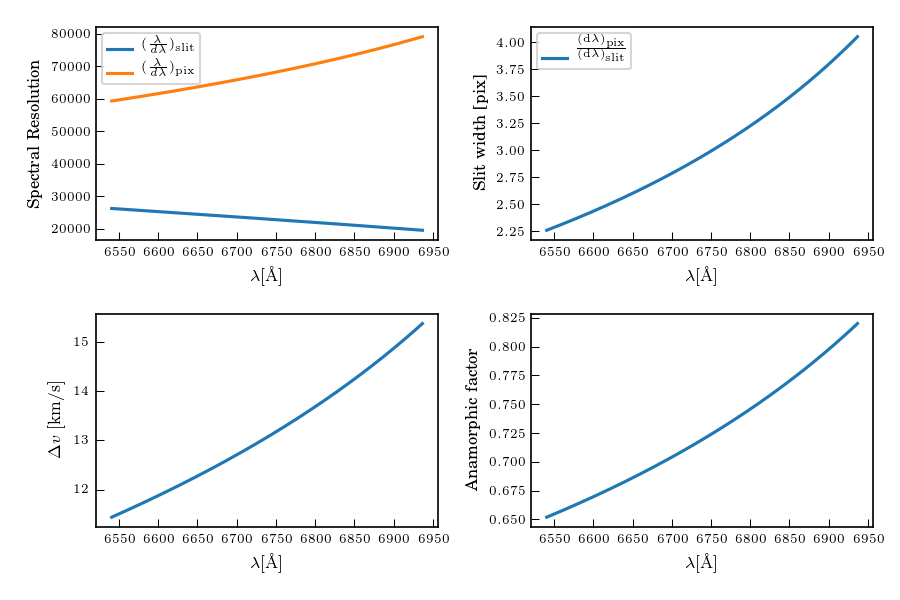

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(6, 4))
axs[0, 0].plot(BenchSetup.wavelengths, BenchSetup.R, 
         label=r'$(\frac{\lambda}{d \lambda})_{{\rm slit}}$')
axs[0, 0].plot(BenchSetup.wavelengths, BenchSetup.wavelengths / BenchSetup.dwavelengths, 
         label=r'$(\frac{\lambda}{d \lambda})_{{\rm pix}}$')
axs[0, 0].set_xlabel(r'$\lambda {\rm [\AA]}$', size=8)
axs[0, 0].set_ylabel('Spectral Resolution', size=8)
axs[0, 0].legend(prop={'size': 6})

axs[0, 1].plot(BenchSetup.wavelengths, BenchSetup.w_reim_spec / BenchSetup.dwavelengths, 
         label=r'$\frac{{\rm (d \lambda)_{pix}}}{{\rm (d \lambda)_{slit}}}}$')
axs[0, 1].set_xlabel(r'$\lambda {\rm [\AA]}$', size=8)
axs[0, 1].set_ylabel('Slit width [pix]', size=8)
axs[0, 1].legend(prop={'size': 6})

axs[1, 0].plot(BenchSetup.wavelengths, BenchSetup.R_vel)
axs[1, 0].set_xlabel(r'$\lambda {\rm [\AA]}$', size=8)
axs[1, 0].set_ylabel(r'$\Delta v ~ {\rm[km / s]}$', size=8)

axs[1, 1].plot(BenchSetup.wavelengths, BenchSetup.anam)
axs[1, 1].set_xlabel(r'$\lambda {\rm [\AA]}$', size=8)
axs[1, 1].set_ylabel('Anamorphic factor', size=8)

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


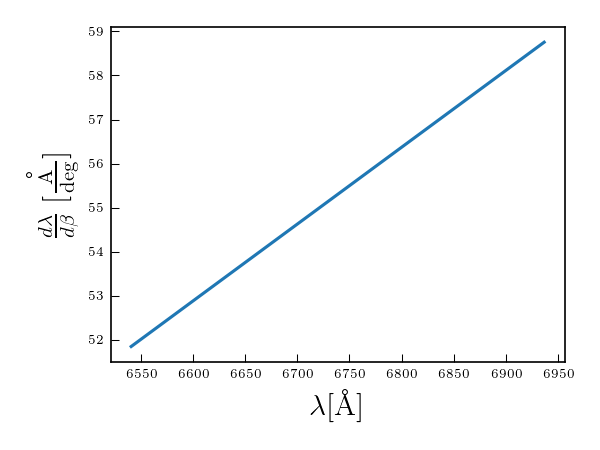

In [11]:
plt.figure()
plt.plot(BenchSetup.wavelengths, BenchSetup.ang_disp.dlam_dbeta(lam=BenchSetup.wavelengths))
plt.xlabel(r'$\lambda {\rm [\AA]}$')
plt.ylabel(r'$\frac{d \lambda}{d \beta} ~ [{\rm \frac{\AA}{deg}}]$')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


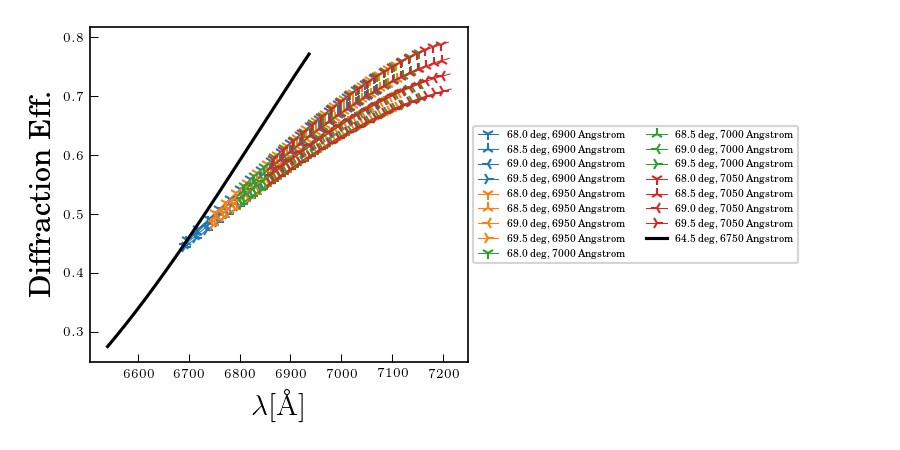

In [12]:
from copy import copy
from itertools import product as iterproduct

BenchSetup_ = copy(BenchSetup)

plt.figure(figsize=(6, 3))
ax = plt.subplot2grid((1,2),(0, 0))

lctrs = np.arange(6900., 7100., 50.) * u.AA
alphas = np.arange(68., 70., .5) * u.deg

cyc = cycler.cycler(color=['C{}'.format(i) for i in range(len(alphas))]) * \
      cycler.cycler(marker=['{}'.format(i+1) for i in range(len(lctrs))])

L_A = iterproduct(lctrs, alphas)

for kwargs, (lctr, alpha) in zip(cyc, L_A):
    setattr(BenchSetup_, 'alpha', alpha)
    setattr(BenchSetup_, 'lam_blaze', lctr)
    setattr(BenchSetup_, 'sol', BenchSetup_._solve())
    EchelleEff_ = SpectrographEfficiency(BenchSetup_)
    ax.plot(BenchSetup_.wavelengths, EchelleEff_(BenchSetup_.wavelengths, BenchSetup_.m), 
            linewidth=0.5, label='{:.1f}, {:.0f}'.format(alpha, lctr), markevery=200, **kwargs)
    
ax.plot(BenchSetup.wavelengths, EchelleEff(BenchSetup.wavelengths, BenchSetup.m), c='k',
        label='{:.1f}, {:.0f}'.format(BenchSetup.alpha, BenchSetup.lam_blaze))
    
ax.set_xlabel(r'$\lambda {\rm [\AA]}$')
ax.set_ylabel(r'Diffraction Eff.')
ax.legend(loc='center left', bbox_to_anchor=(1., 0.5), ncol=2, prop={'size': 5})
plt.tight_layout()
plt.show()

## Compute redshift limits

Accessible redshift range must observe all lines.

In [13]:
lam_lines = np.array([v.value for v in elines.values()]) * elines['Ha'].unit
lam_llim, lam_ulim = BenchSetup.lam_range
def redshift_is_accessible(z, lam_lines=lam_lines, lam_llim=lam_llim, lam_ulim=lam_ulim, vel=200. * u.km / u.s):
    '''
    returns True if lam_lims encomapsses all wavelengths lam_lines after they have been redshifted by z
    '''
    # test absolute wavelength limits
    lam_lines_z = lam_lines + (lam_lines * np.log(1. + z))
    above_lam_llim = (lam_lines_z >= (lam_llim * (1. + (vel / c.c).decompose())))
    below_lam_llim = (lam_lines_z <= (lam_ulim / (1. + (vel / c.c).decompose())))
    
    return np.all(np.row_stack([above_lam_llim, below_lam_llim]))

_zgrid = np.linspace(0.0, 0.1, 600)
_z_is_accessible = np.array(list(map(redshift_is_accessible, _zgrid)))
good_zs = _zgrid[_z_is_accessible]

zmin = good_zs.min()
zmax = good_zs.max()

print('redshift range: [{:.04f}, {:.04f}]'.format(zmin, zmax))

redshift range: [0.0000, 0.0301]


# Parse the catalog

Start by loading the catalog of objects, and cut non-galaxies.

Also cut low-mass stuff and focus on MW-like disks

In [14]:
drpall = t.Table.read('/usr/data/minhas2/tremonti/manga/mpl5_data/drpall-v2_0_1.fits')
drpall = drpall[drpall['nsa_z'] != -9999.]
drpall.add_index('plateifu')
print(drpall.colnames)

['plate', 'ifudsgn', 'plateifu', 'mangaid', 'versdrp2', 'versdrp3', 'verscore', 'versutil', 'versprim', 'platetyp', 'srvymode', 'objra', 'objdec', 'ifuglon', 'ifuglat', 'ifura', 'ifudec', 'ebvgal', 'nexp', 'exptime', 'drp3qual', 'bluesn2', 'redsn2', 'harname', 'frlplug', 'cartid', 'designid', 'cenra', 'cendec', 'airmsmin', 'airmsmed', 'airmsmax', 'seemin', 'seemed', 'seemax', 'transmin', 'transmed', 'transmax', 'mjdmin', 'mjdmed', 'mjdmax', 'gfwhm', 'rfwhm', 'ifwhm', 'zfwhm', 'mngtarg1', 'mngtarg2', 'mngtarg3', 'catidnum', 'plttarg', 'manga_tileid', 'nsa_iauname', 'ifudesignsize', 'ifutargetsize', 'ifudesignwrongsize', 'zmin', 'zmax', 'szmin', 'szmax', 'ezmin', 'ezmax', 'nsa_field', 'nsa_run', 'nsa_camcol', 'nsa_version', 'nsa_nsaid', 'nsa_nsaid_v1b', 'nsa_z', 'nsa_zdist', 'nsa_sersic_absmag', 'nsa_elpetro_absmag', 'nsa_elpetro_amivar', 'nsa_sersic_mass', 'nsa_elpetro_mass', 'nsa_elpetro_ba', 'nsa_elpetro_phi', 'nsa_extinction', 'nsa_elpetro_th50_r', 'nsa_petro_th50', 'nsa_petro_flux',

<IPython.core.display.Javascript object>


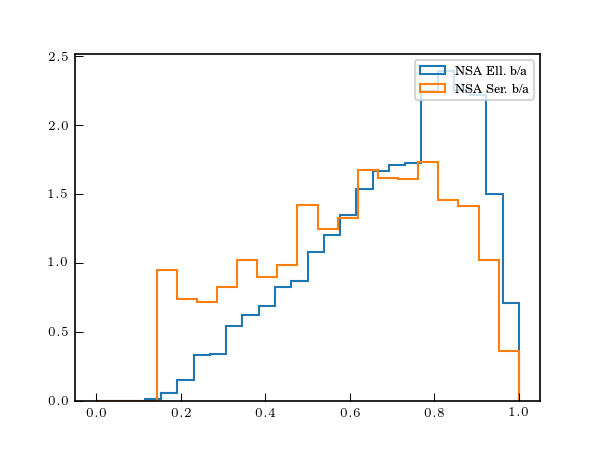

In [15]:
plt.figure()
plt.hist(drpall['nsa_elpetro_ba'], range=[0., 1.], bins='auto', histtype='step', label='NSA Ell. b/a', normed=True)
plt.hist(drpall['nsa_sersic_ba'], range=[0., 1.], bins='auto', histtype='step', label='NSA Ser. b/a', normed=True)
plt.legend(prop={'size': 6.})
plt.show()

In [16]:
cat = drpall
cat.sort('objra')
cat = cat[(cat['nsa_z'] >= zmin) * (cat['nsa_z'] <= zmax)]
cat = cat[cat['ifudesignsize'] >= 37]

# accept only galaxies that are within 4 hours of overhead hour angle @ middle of night
hourangle_range = RA_overhead_at_midnight.to(u.hourangle) + np.array([-4.5, 4.5]) * u.hourangle
if hourangle_range[0] < 0. * u.hourangle:
    hourangle_range[0] += 24. * u.hourangle
if hourangle_range[-1] >= 24. * u.hourangle:
    hourangle_range[-1] -= 24. * u.hourangle
    
good_hourangle = (((cat['objra'] * u.deg).to(u.hourangle) >= hourangle_range.min()) * \
                  ((cat['objra'] * u.deg).to(u.hourangle) <= hourangle_range.max()))
cat = cat[good_hourangle]

cat['logmstar'] = np.log10(cat['nsa_sersic_mass'])
#cat = cat[cat['logmstar'] > 9.5]

cat = cat[(cat['nsa_sersic_absmag'][:, 3] - cat['nsa_sersic_absmag'][:, 4]) < .7]
cat = cat[cat['nsa_elpetro_th50_r'] > (5. * BenchSetup.w0_ang.to(u.arcsec).value)]
cat = cat[cat['nsa_sersic_ba'] > 0.65]

cat['plateifu', 'objra', 'objdec', 'nsa_elpetro_th50_r', 'logmstar', 'nsa_z'].pprint(max_width=-1, max_lines=-1)

print('\n')
print('log min M*:', cat['logmstar'].min())
print('log max M*:', cat['logmstar'].max())

 plateifu      objra         objdec    nsa_elpetro_th50_r    logmstar     nsa_z   
---------- ------------- ------------- ------------------ ------------- ----------
 8458-3702      147.5625      45.95731            4.89035 9.44051552111  0.0248702
8459-12702 147.585854164 43.1455699673              9.512 9.12421720873  0.0170809
 8459-6102 147.990674372 43.4140430617            5.30662  8.8983795826  0.0158773
8459-12705 148.117076795 42.8191413496            10.9418  9.2178733186   0.016087
 8459-9102 149.888880629 43.6605000576            7.75227 8.59469302681  0.0170491
8456-12704 150.842878378 45.7635360671             10.278 9.52402723714  0.0255084
8456-12701 151.191285745 44.7057800061            14.9291 9.75469150682  0.0231141
 8456-9102 151.233963795 46.7237362775            6.91803 9.47284710066  0.0245447
8453-12701 151.309949901 46.6508890341            10.6104 10.0887596068  0.0251003
8455-12701 154.731809916 40.6129387518            5.81167  9.8185795214  0.0292303
8568

In [49]:
obs_constraints = [ap.AltitudeConstraint(max=85. * u.deg),
                   ap.AirmassConstraint(max=1.5)]

targets = [ap.FixedTarget(SkyCoord(row['objra'] * u.deg, row['objdec'] * u.deg), name=row['plateifu'])
           for row in cat]

def target_priority_at_time(constraints, catalog, observer, starttime, duration):
    '''
    subjects a table of targets to a list of constraints over some range of time, then prioritizes
        highest available stellar mass
    '''
    targets = [ap.FixedTarget(SkyCoord(row['objra'] * u.deg, row['objdec'] * u.deg), name=row['plateifu'])
               for row in catalog]
    time_delt = 10. * u.min
    ntimes = int((duration / time_delt).decompose().value) + 1
    times = starttime + 10. * u.min * np.linspace(0., ntimes, ntimes + 1)
    observable_at_all_times = np.multiply.reduce(
        ([ap.is_observable(constraints=obs_constraints, observer=observer, targets=targets, times=t_)
         for t_ in times]))
    filtered_catalog = catalog[observable_at_all_times.astype(bool)]
    return filtered_catalog
    
cat_time = target_priority_at_time(
    constraints=obs_constraints, catalog=cat, observer=KPNO, starttime=KPNO_times_n1[-5],
    duration=2.5 * u.hr)

cat_time['plateifu', 'objra', 'objdec', 'logmstar', 'nsa_z'].pprint(
        max_width=-1, max_lines=-1)

 plateifu      objra         objdec       logmstar     nsa_z  
---------- ------------- ------------- ------------- ---------
8611-12702 260.718888104  60.129590188 10.0246457278 0.0276302
7991-12704 261.321053643 56.9518773841 9.73240260647 0.0250049
 7990-6104 261.607611692 58.5888563574 9.99193676189  0.026199
8611-12705 261.979027094 59.7212052974 9.01290046687 0.0180936
8611-12701 262.257375976  60.089399624 9.63530979313 0.0205096
7990-12701 263.150147507 56.8452564886 9.87967722683 0.0297644


In [18]:
coords = SkyCoord(cat['objra'] * u.deg, cat['objdec'] * u.deg)
coordfile_text = [' '.join((n, c)) for c, n in zip(coords.to_string('decimal', decimal=True), cat['plateifu'])]

with open('coordfile.txt', 'w') as f:
    f.write('\n'.join(coordfile_text))

## What wavelengths are we interested in?

In [19]:
targ_elines = cat['plateifu', 'nsa_z', 'logmstar']

for k in elines.keys():
    targ_elines[k] = np.log(1. + targ_elines['nsa_z']) * elines[k] + elines[k]
    
lmin = targ_elines['[NII]_1', '[NII]_2', '[SII]_1', '[SII]_2', 'Ha'].as_array().view((float, len(elines))).min(axis=1)
lmax = targ_elines['[NII]_1', '[NII]_2', '[SII]_1', '[SII]_2', 'Ha'].as_array().view((float, len(elines))).max(axis=1)
    
targ_elines['lmin'] = lmin * u.AA
targ_elines['lmax'] = lmax * u.AA

def line_in_bad_band(row, bad_band):
    keys = ['[NII]_1', '[NII]_2', '[SII]_1', '[SII]_2', 'Ha']
    for k in keys:
        if bad_band[0].value < row[k] < bad_band[1].value:
            return True
    else:
        return False
    
bad_band=[6867. * u.AA, 6927. * u.AA]
    
in_telluric = np.array([line_in_bad_band(row, bad_band) for row in targ_elines])
#cat = cat[~in_telluric]
#targ_elines = targ_elines[~in_telluric]

cat['telluric'] = in_telluric

cat['plateifu', 'objra', 'objdec', 'nsa_elpetro_th50_r', 'logmstar', 'nsa_z'].pprint(max_width=-1, max_lines=-1)

 plateifu      objra         objdec    nsa_elpetro_th50_r    logmstar     nsa_z   
---------- ------------- ------------- ------------------ ------------- ----------
 8458-3702      147.5625      45.95731            4.89035 9.44051552111  0.0248702
8459-12702 147.585854164 43.1455699673              9.512 9.12421720873  0.0170809
 8459-6102 147.990674372 43.4140430617            5.30662  8.8983795826  0.0158773
8459-12705 148.117076795 42.8191413496            10.9418  9.2178733186   0.016087
 8459-9102 149.888880629 43.6605000576            7.75227 8.59469302681  0.0170491
8456-12704 150.842878378 45.7635360671             10.278 9.52402723714  0.0255084
8456-12701 151.191285745 44.7057800061            14.9291 9.75469150682  0.0231141
 8456-9102 151.233963795 46.7237362775            6.91803 9.47284710066  0.0245447
8453-12701 151.309949901 46.6508890341            10.6104 10.0887596068  0.0251003
8455-12701 154.731809916 40.6129387518            5.81167  9.8185795214  0.0292303
8568

# Plot the downselected catalog

<IPython.core.display.Javascript object>


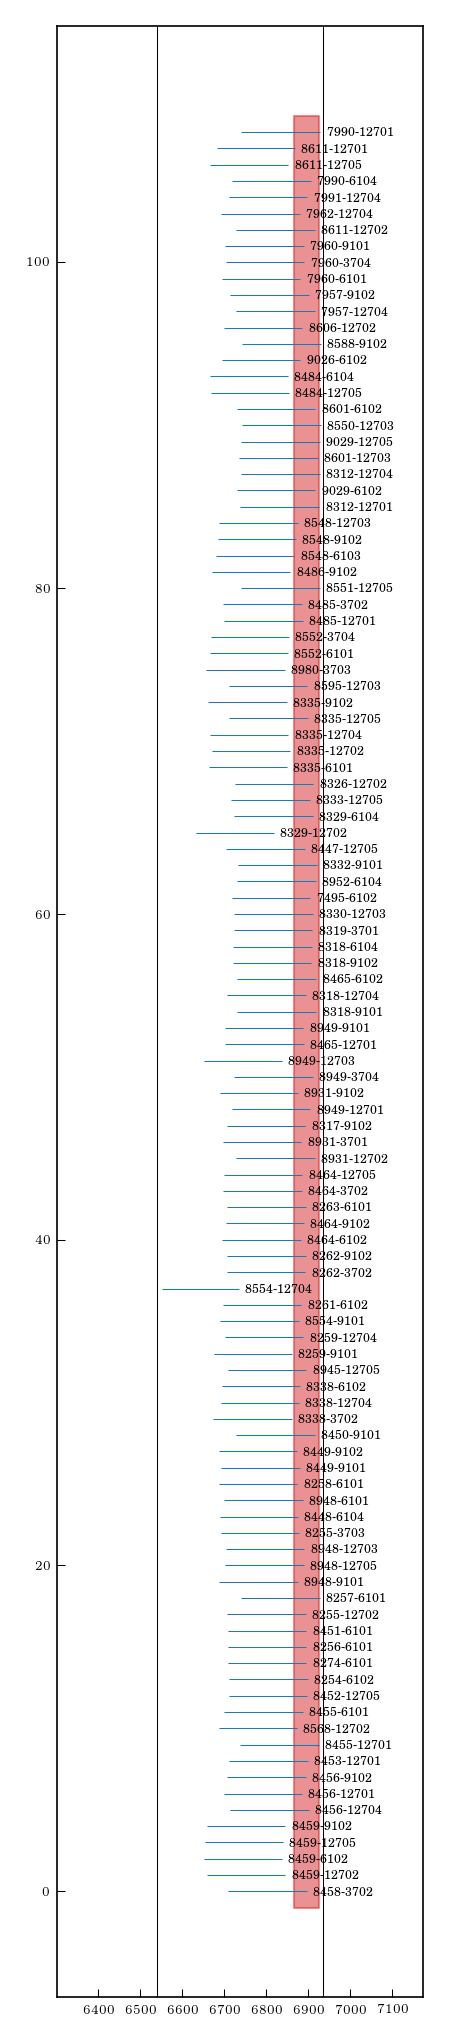

In [20]:
fig_ht = 2.5 * (len(cat) / 20.)
fig = plt.figure(figsize=(3., fig_ht))
ax = plt.gcf().add_subplot(111)
ax = BenchSetup.lam_range_plot(ax)

ax.errorbar(
    targ_elines['Ha'], np.array(range(len(targ_elines))),
    xerr=[(targ_elines['Ha'] - targ_elines['lmin']),
          (targ_elines['lmax'] - targ_elines['Ha'])], markersize=4.,
    linestyle='None', linewidth=0.5)

xloc = targ_elines['lmax']
ngal = 0
for i, row in enumerate(targ_elines):
    ax.text(row['lmax'] + 15, i - 0.25, row['plateifu'], size=6.)
        
ax.fill_betweenx(y=[-1., len(targ_elines)], x1=bad_band[0], x2=bad_band[1], color='C3', alpha=0.5, zorder=0)

plt.tight_layout()
plt.show()

Set up fiducial models for galaxies

In [21]:
# extract Ha flux map, and change to Ha surface brightness
def emline_SB(dap, key, snr_min=3.):
    el_f_hdu = dap['EMLINE_GFLUX']
    el_f_iv_hdu = dap['EMLINE_GFLUX_IVAR']
    
    # get a mapping from eline key to channel key
    v2k = {v: k for (k, v) in el_f_hdu.header.items()}
    # get a mapping from channel key to channel
    cstring2ix = lambda s: int(s[1:]) - 1
    
    ix = cstring2ix(v2k[key])
    
    # flux and ivar
    f = el_f_hdu.data[ix, ...]
    f_ivar = el_f_iv_hdu.data[ix, ...]
    
    # SNR minimum
    snr = f * np.sqrt(f_ivar)
    f_mask = (snr < snr_min)
    
    # units for bin area and flux ==> surface brightness
    bin_area = dap['BIN_AREA'].data * u.arcsec**2.
    f_unit = u.Unit('1e-17 erg s-1 cm-2')
    SB_unit = f_unit / bin_area
    
    return f * SB_unit, f_mask

from astropy.wcs.utils import skycoord_to_pixel, proj_plane_pixel_scales, custom_frame_mappings

def make_wcs_offset(dap):
    # load dummy HDU
    hdu = dap['SPX_MFLUX']
    
    # un-offset WCS header
    wcs_orig = WCS(hdu.header)
    
    origin = SkyCoord(
        ra=dap[0].header['IFURA'] * u.deg, dec=dap[0].header['IFUDEC'] * u.deg)
    wcs_new = origin.skyoffset_frame()

    return wcs_new

def angle_to_imgpos(p, n, ctr):
    '''
    convert and angular offset into an offset in image pixel coordinates
    
    params:
     - n: number of pixels in each axis (shape of image)
     - p: position of the fiber (in sky coordinates relative to center of IFU)
     - ctr: position of center of IFU
    '''
    
    if not (len(p) == len(n) == len(ctr) == 2):
        raise ValueError('sky-coordinates only work in 2D!')
    
    # x coordinate is counted backwards in image coordinates
    sgn = (-1., 1.)
    imcoo = tuple((nn / 2. + ss * ((pp - cc) / pixscale)).value 
                   for ss, pp, nn, cc in zip(sgn, p, n, ctr))
    return imcoo
    

# generate rotation matrix
rotmatrix = lambda a: np.array([[np.cos(a), -np.sin(a)], 
                                [np.sin(a),  np.cos(a)]])

def ifu_overlay(astrometry_tab, ifu_ctr, ax, dither=None, offset=None, ctr=None, **kwargs):
    '''
    put a HexPak IFU overlay defined in `astrometry_tab` and with center location
        `ifu_ctr` atop image on axes `ax`
        
    `offset` is a pure-spatial (array-like) specification of a dither pattern, `dither` is
        an array-like specification with an offset of `dither[0]` at angle `dither[1]`
        CCW from East
    '''
    if ctr is None:
        ctr = [0. * u.arcsec, 0. * u.arcsec]
    
    if (dither is None) and (offset is None):
        offset = [0. * u.arcsec, 0. * u.arcsec]
    elif (dither is not None) and (offset is not None):
        raise ValueError('don\'t specify both offset (spatial) and dither (angular-radial)')
    elif dither is not None:
        offset = np.array([1., 0.]) * dither[0]
        offset = offset.dot(rotmatrix(dither[1]))
    elif offset is not None:
        pass
    
    for row in astrometry_tab:
        fib_ctr = [row['d_alpha'] * u.deg, row['d_delta'] * u.deg]
        fib_ctr = [(v1 + v2 + v3).to(u.deg) for v1, v2, v3 in zip(fib_ctr, offset, ctr)]
        X, Y = angle_to_imgpos(p=fib_ctr, n=Ha_map.shape, ctr=ifu_ctr)
        R = (row['R'] * u.arcsec / pixscale).value
        ax.add_artist(Circle((X, Y), R, **kwargs))
    
    return ax

In [22]:
# read in HexPak astrometry table
HexPak_astrometry = t.Table.read('hexpak_overlay.dat', format='ascii', delimiter=' ')
HexPak_astrometry['d_alpha'][HexPak_astrometry['d_alpha'] > 180.] -= 360.
#print(HexPak_astrometry)

ctr_row = HexPak_astrometry[84]
ifu_ctr = [ctr_row['d_alpha'] * u.deg, ctr_row['d_delta'] * u.deg]

lower_innercore_row = HexPak_astrometry[86]

# define standard dither offsets for inner core
d_innercore = np.abs(ctr_row['d_delta'] - lower_innercore_row['d_delta']) * u.deg
d_outer = (3.806 * u.arcsec).to(u.deg)

/usr/data/minhas/zpace/miniconda3/envs/obsplan/lib/python3.5/site-packages/astropy/units/quantity.py:951: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__truediv__(other)
/usr/data/minhas/zpace/miniconda3/envs/obsplan/lib/python3.5/site-packages/astropy/units/quantity.py:924: RuntimeWarning: invalid value encountered in multiply
  return super(Quantity, self).__mul__(other)


<IPython.core.display.Javascript object>


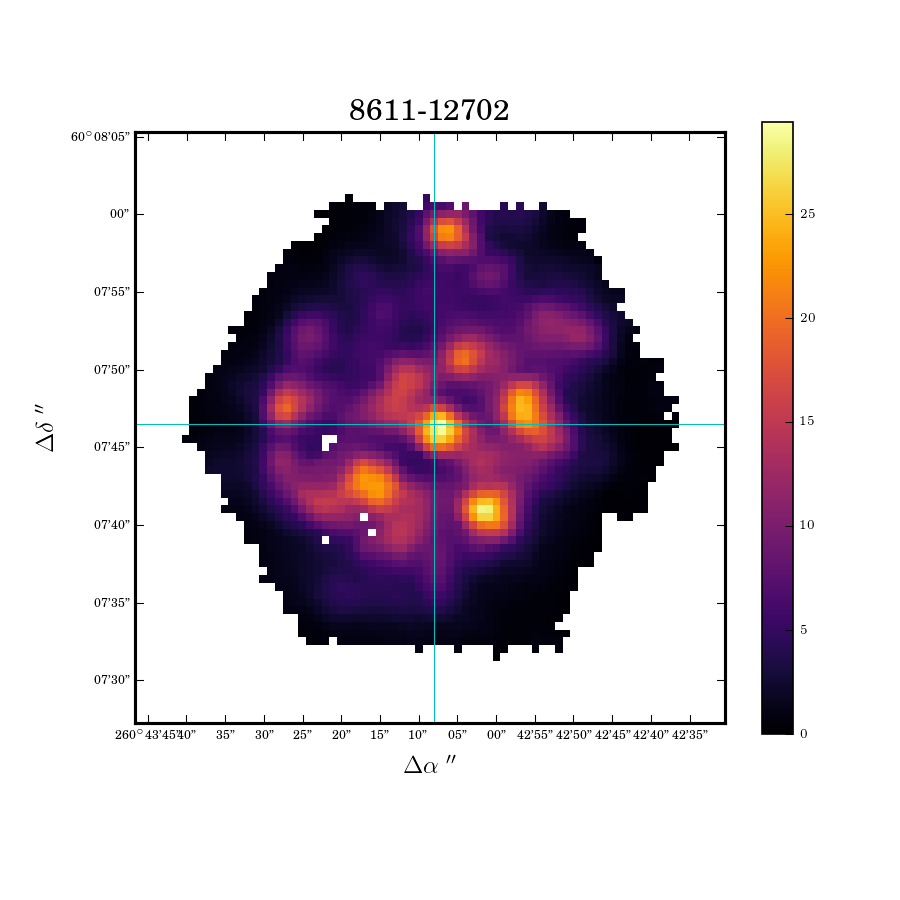

In [80]:
# fiber overlay
from astropy.visualization.wcsaxes import SphericalCircle
from matplotlib.patches import Circle

# select object
row_ = cat_time[0]
plateifu = row_['plateifu']
row = cat.loc[plateifu]
pixscale = 0.5 * u.arcsec
coresize = 3. * BenchSetup.w0_ang.to(u.arcsec)
ifusize = 40.85 * u.arcsec

# load MAPS
dap = m.load_dap_maps(plate=str(row['plate']), ifu=str(row['ifudsgn']), mpl_v='MPL-5', kind='SPX-GAU-MILESHC')

# prepare Ha SB map
obj_ctr = SkyCoord(ra=dap[0].header['OBJRA'] * u.deg, dec=dap[0].header['OBJDEC'] * u.deg)
wcs_orig = WCS(dap['SPX_MFLUX'].header)
wcs_offset = make_wcs_offset(dap)
Ha_map, Ha_map_mask = emline_SB(dap, key='Ha-6564')

try:
    plt.close(fig)
except:
    pass

# make figure
fig = plt.figure(figsize=(6., 6.))
ax = fig.add_subplot(111, projection=wcs_orig)
im = ax.imshow(np.ma.array(Ha_map.value, mask=Ha_map_mask), aspect='equal', cmap='inferno', vmin=0.)
plt.colorbar(im, ax=ax, shrink=0.8)

ax.set_xlabel(' '.join((r'$\Delta \alpha$', u.arcsec._repr_latex_())))
ax.set_ylabel(' '.join((r'$\Delta \delta$', u.arcsec._repr_latex_())))
ax.set_title(row['plateifu'])


# plot 1 Re
Re = row['nsa_elpetro_th50_r']
#ax.add_patch(Circle(tuple(map(lambda x: x / 2., Ha_map.shape)), 
#                    (Re / pixscale).value, facecolor='None', edgecolor='r', linewidth=2.))

# center position
obj_offset = [7. * u.arcsec, -4. * u.arcsec]
#ifu_overlay(astrometry_tab=HexPak_astrometry, ifu_ctr=ifu_ctr, ctr=obj_offset,
#            ax=ax, facecolor='None', edgecolor='C1', linewidth=1.)

for i in range(2):
    ax.coords[i].set_ticklabel(size=6.)
    ax.coords[i].set_ticks(spacing=5. * u.arcsec)
    ax.coords[i].set_format_unit(u.arcsec)
    
ax.axhline(Ha_map.shape[0] // 2, c='c', linewidth=0.5)
ax.axvline(Ha_map.shape[1] // 2, c='c', linewidth=0.5)

fig.tight_layout()
fig.subplots_adjust(left=0.15, bottom=0.1, top=0.95)
fig.show()

# Transmission by various components

<IPython.core.display.Javascript object>


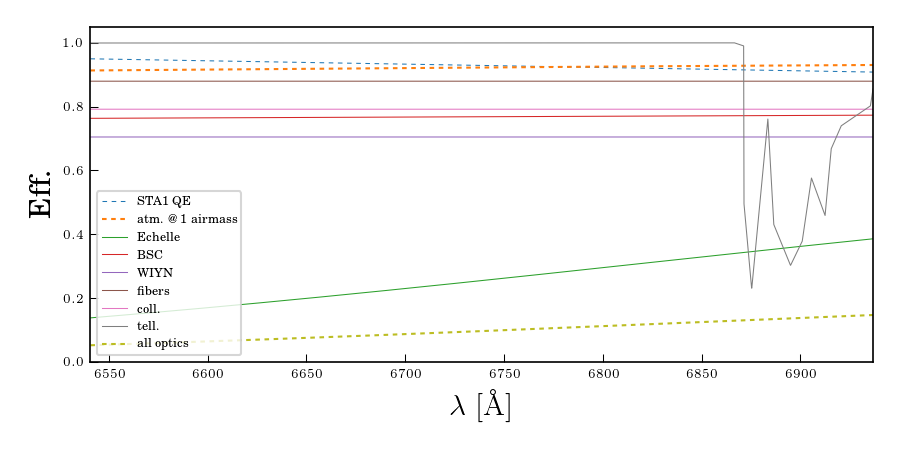

In [51]:
# efficiency curves
from scipy.interpolate import interp1d

# detector
STA1_QE = interp1d(x=np.linspace(3000., 11000., 15) * u.AA,
                   y=np.array([.485, .747, .777, .818, .905, .987, .962,
                               .902, .862, .791, .685, .523, .357, .09, .02]),
                   kind='linear', bounds_error=False, fill_value=0.)

# camera
SimCam_tr = lambda l: .45 * np.ones_like(l)
BSC_tr = interp1d(x=np.array([3800., 4000., 8000., 11000.]) * u.AA,
                  y=np.array([.45, .7, .8, .7]),
                  kind='linear', bounds_error=False, fill_value=0.)

# grating
grating_eff = lambda l: .5 * EchelleEff(l, BenchSetup.m)
#grating_eff = lambda l: 0.32 * 0.89 * np.ones_like(l)

# collimator (reflectance + vignetting)
# Bershady et al 05
coll_tr = lambda l: .89**2. * np.ones_like(l)

# fibers
# Bershady et al 05
fiber_tr = lambda l: .88 * np.ones_like(l)

# telescope
WIYN_tr = lambda l: .89**3. * np.ones_like(l)

# total instrument efficiency
optics_eff = lambda l: WIYN_tr(l) * fiber_tr(l) * coll_tr(l) * grating_eff(l) * BSC_tr(l)

# atmosphere
atm_lam = np.array([6435., 6790., 7100., 7550., 7780.])
atm_mag = np.array([.104, 0.084, 0.071, 0.061, 0.055])
atm_tr = interp1d(x=atm_lam, y=10.**(-0.4 * atm_mag),
                  kind='linear', bounds_error=False, fill_value=0.)

# telluric absorption
telluric = t.Table.read('telluric_abs.csv', names=['l', 'tr'], format='csv', data_start=2)
atm_tell = interp1d(x=telluric['l'], y=telluric['tr'], kind='linear', bounds_error=False, fill_value=1.)

plt.figure(figsize=(6, 3))

eff_lam = BenchSetup.wavelengths

plt.plot(eff_lam, STA1_QE(eff_lam), linewidth=0.5, linestyle=':', label='STA1 QE')
plt.plot(eff_lam, atm_tr(eff_lam), linewidth=1., linestyle=':', label='atm. @ 1 airmass')
plt.plot(eff_lam, grating_eff(eff_lam),
         linewidth=0.5, label='Echelle')
plt.plot(eff_lam, BSC_tr(eff_lam), linewidth=0.5, label='BSC')
plt.plot(eff_lam, WIYN_tr(eff_lam), linewidth=0.5, label='WIYN')
plt.plot(eff_lam, fiber_tr(eff_lam), linewidth=0.5, label='fibers')
plt.plot(eff_lam, coll_tr(eff_lam), linewidth=0.5, label='coll.')
plt.plot(eff_lam, atm_tell(eff_lam), linewidth=0.5, label='tell.')

plt.plot(eff_lam, optics_eff(eff_lam), linewidth=1., linestyle=':', label='all optics')

plt.xlim(list(map(lambda x: x.value, BenchSetup.lam_range)))
plt.ylim([0., 1.05])

plt.xlabel(r'$\lambda ~ {\rm [\AA]}$')
plt.ylabel(r'Eff.')

plt.legend(loc='best', prop={'size': 6.})
plt.tight_layout()
plt.show()

# Predict photons received from object at wavelength

Next step: assume some SFR, pull out Ha SB, try to predict S/N

In [52]:
from synthdata import IFUCubeObserver, unc_of_cts

In [53]:
Obsv = IFUCubeObserver.from_drpall_row(row=cat.loc[plateifu], lamlims=BenchSetup.wavelengths,
                                       lspax=(0.5 * u.arcsec), mpl_v='MPL-5')

In [62]:
ix_ctr = (np.median(Obsv.II), np.median(Obsv.JJ))
ix = np.unravel_index(np.ma.argmax(np.ma.array(Ha_map, mask=Ha_map_mask)), Ha_map.shape)

spec_cts_rate = Obsv.mean(ctr=ix, lams=BenchSetup.wavelengths, dlams=BenchSetup.dwavelengths, 
                          D_fib=BenchSetup.w0_ang, effs=[atm_tr, optics_eff, STA1_QE, atm_tell],
                          A_scope=BenchSetup.A_scope, spat_samples=50)
exptime = (20. * u.min)
spec_ct = (spec_cts_rate * exptime).to(u.ct)
spec_ct_unc = unc_of_cts(spec_ct)

<IPython.core.display.Javascript object>


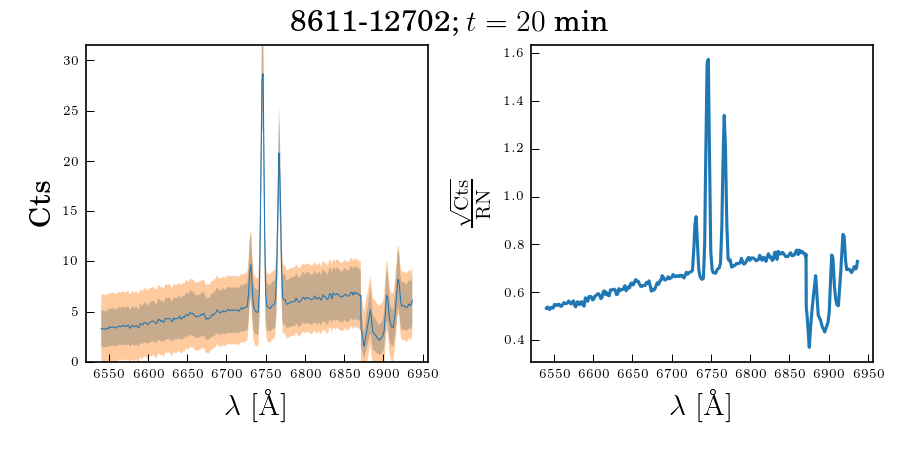

In [63]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

ax1.fill_between(x=BenchSetup.wavelengths.value, y1=(spec_ct - spec_ct_unc).value, 
                 y2=(spec_ct + spec_ct_unc).value, alpha=0.4, facecolor='C0')
ax1.fill_between(x=BenchSetup.wavelengths.value, y1=(spec_ct - BenchSetup.RN).value,
                 y2=(spec_ct + BenchSetup.RN).value, alpha=0.4, facecolor='C1')
ax1.plot(BenchSetup.wavelengths.value, spec_ct.value, linewidth=0.5)
ax1.set_ylim([0., 1.1 * spec_ct.value.max()])

ax1.set_xlabel(r'$\lambda ~ [{\rm \AA}]$')
ax1.set_ylabel('Cts')

ax2.plot(BenchSetup.wavelengths, spec_ct_unc / BenchSetup.RN)
ax2.set_xlabel(r'$\lambda ~ [{\rm \AA}]$')
ax2.set_ylabel(r'$\frac{\sqrt{{\rm Cts}}}{{\rm RN}}$')

plt.gcf().suptitle(r'{0}; $t = {1.value:.0f} ~ {1.unit:latex}$'.format(cat.loc[plateifu]['plateifu'], exptime))

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [64]:
N_obs = 6
t_obs = 20. * u.min

sky = 3.0e-3 * u.ct / u.s

Flam_src, Flam_unc = Obsv.observe_Flam(
    N_obs=N_obs, t_obs=t_obs, RN=BenchSetup.RN, dark_ct_rate=BenchSetup.dark,
    sky_ct_rate=sky, ctr=ix, lams=BenchSetup.wavelengths, dlams=BenchSetup.dwavelengths, 
    D_fib=BenchSetup.w0_ang, effs=[atm_tr, optics_eff, STA1_QE],
    A_scope=BenchSetup.A_scope, spat_samples=50)

<IPython.core.display.Javascript object>


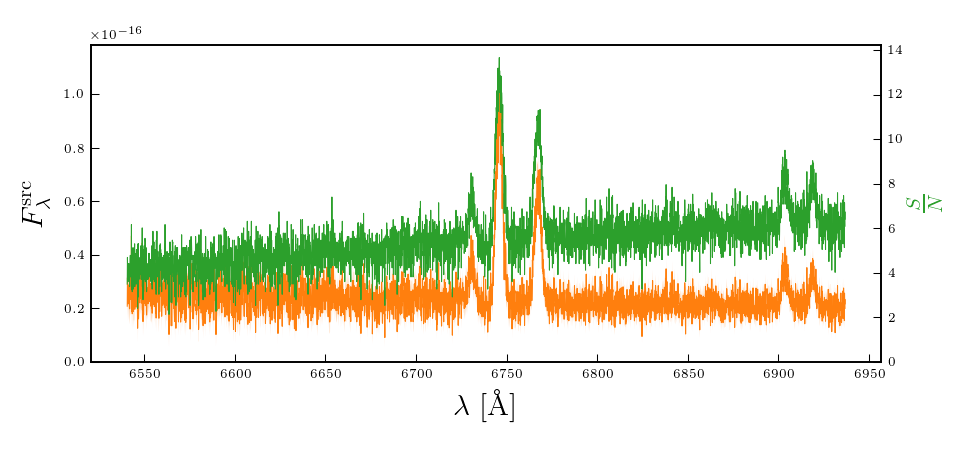

In [65]:
_, ax = plt.subplots(1, 1, figsize=(6.5, 3))
ax.fill_between(x=BenchSetup.wavelengths.value, y1=(Flam_src - Flam_unc).value, y2=(Flam_src + Flam_unc).value,
                facecolor='C1', alpha=0.4)
ax.plot(BenchSetup.wavelengths, Flam_src, linewidth=0.5, c='C1')

ax_ = ax.twinx()
ax_.plot(BenchSetup.wavelengths, (Flam_src / Flam_unc).decompose(), c='C2', linewidth=0.5)
ax_.set_ylim([0., ax_.get_ylim()[1]])
ax_.set_ylabel(r'$\frac{S}{N}$', color='C2')

ax.set_xlabel(r'$\lambda ~ [{\rm \AA}]$')
ax.set_ylabel(r'$F^{{\rm src}}_{\lambda}$')
plt.tight_layout()
plt.show()

# Fit gaussians to the "observed" spectrum

In [58]:
import scipy.optimize as spopt

In [59]:
def gaussian(l, A, l0, sig):
    '''
    dummy function to produce a single gaussian of amplitude A, location l0, and width sig
        on a grid l
    '''
    return A * np.exp(-(l - l0)**2. / (2. * sig**2.))
    
def multigauss(l, *args):
    n = 5
    args = np.array(args).reshape((-1, n))
    A, l0, sig = args[0, :], args[1, :], args[2, :]
    gaussians = np.zeros_like(l)
    for A_, l0_, sig_ in zip(A, l0, sig):
        gaussians += gaussian(l, A_, l0_, sig_)
    return gaussians

<IPython.core.display.Javascript object>


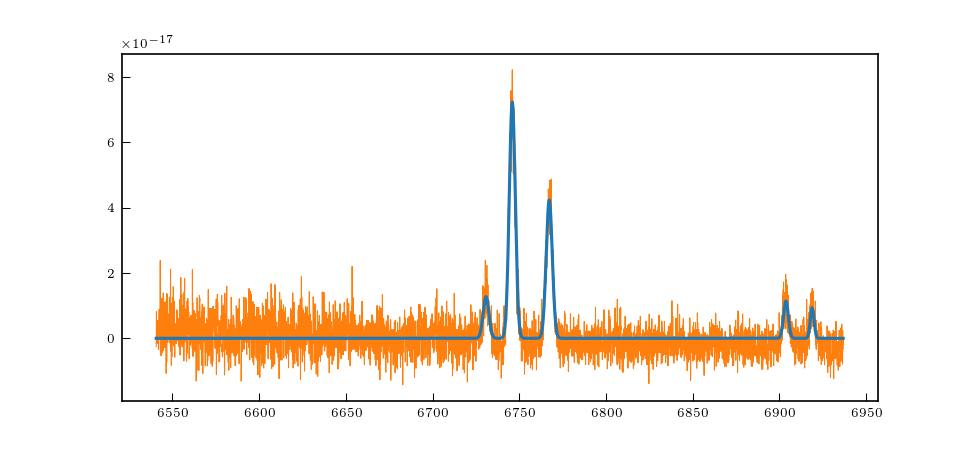

In [66]:
# set starting parameters
z = row['nsa_z']
A_start = [0.15e-17, 3.0e-17, 1.0e-17, 1.0e-17, 0.25e-17]
l0_start = [elines['[NII]_1'].value * (1. + z), elines['Ha'].value * (1. + z), elines['[NII]_2'].value * (1. + z), 
            elines['[SII]_1'].value * (1. + z), elines['[SII]_2'].value * (1. + z)]
sig_start = [2., 2., 2., 2., 2.]
p0 = A_start + l0_start + sig_start

ydata = Flam_src.value
ydata -= np.median(Flam_src)
popt, pcov = spopt.curve_fit(
    f=multigauss, xdata=BenchSetup.wavelengths.value, ydata=ydata, p0=p0, 
    sigma=Flam_unc.value, absolute_sigma=True, maxfev=10000)

plt.figure(figsize=(6.5, 3))

plt.plot(BenchSetup.wavelengths, Flam_src, linewidth=0.5, c='C1')
plt.plot(BenchSetup.wavelengths, multigauss(BenchSetup.wavelengths.value, popt))
plt.show()

In [67]:
for i, p in enumerate(popt):
    print('p: {0:.3e} +/- {1:.3e} ({2:.1f}%)'.format(p, np.sqrt(pcov[i, i]), 100. * np.sqrt(pcov[i, i]) / p))

p: 1.276e-17 +/- 1.106e-18 (8.7%)
p: 7.230e-17 +/- 1.524e-18 (2.1%)
p: 4.231e-17 +/- 1.262e-18 (3.0%)
p: 1.141e-17 +/- 9.443e-19 (8.3%)
p: 9.343e-18 +/- 1.025e-18 (11.0%)
p: 6.731e+03 +/- 1.589e-01 (0.0%)
p: 6.746e+03 +/- 3.622e-02 (0.0%)
p: 6.767e+03 +/- 5.419e-02 (0.0%)
p: 6.904e+03 +/- 1.277e-01 (0.0%)
p: 6.919e+03 +/- 1.341e-01 (0.0%)
p: -1.664e+00 +/- 1.559e-01 (-9.4%)
p: 1.718e+00 +/- 3.323e-02 (1.9%)
p: 1.758e+00 +/- 5.110e-02 (2.9%)
p: 1.388e+00 +/- 1.246e-01 (9.0%)
p: -1.096e+00 +/- 1.312e-01 (-12.0%)
